# Filter by WER

> "Also, find determiner location"

- branch: master
- hidden: true
- categories: [hsi, wer, groundinggpt]

In [21]:
PATHS = (
    ("/tmp/numered_all.json", "/tmp/gpt4o-generated-speech"),
    ("/tmp/ggpt_numbered.json", "/tmp/groundinggpt-generated-speech"),
    ("/tmp/ggpt_numbered2.json", "/tmp/groundinggpt-generated-speech2")
)

In [1]:
import json

with open("/tmp/numered_all.json") as inf:
    data = json.load(inf)

In [9]:
from string import punctuation

punct = set(punctuation)

In [ ]:
def gather_phrase(text):
    words = text.split(" ")
    phrase = []
    inphrase = False
    start = 0
    for idx, word in enumerate(words):
        if inphrase:
            if word.endswith("*") or (word[-1] in punct and word[-2] == "*"):
                word = word.replace("*", "")
                phrase.append(word)
                inphrase = False
            else:
                phrase.append(word)
        else:
            if word.startswith("*"):
                if word.endswith("*") or (word[-1] in punct and word[-2] == "*"):
                    return idx, word.replace("*", "")
                else:
                    phrase.append(word.strip("*"))
                    start = idx
                inphrase = True
            else:
                continue
    return start, (" ".join(phrase)).strip("*")

In [ ]:
def index_of_determiner(phrase):
    dp = gather_phrase(phrase)
    words = phrase.split(" ")
    for i, word in enumerate(words):
        if word in ["this", "that", "these", "those"]:
            return i
    return -1

In [ ]:
def clean_text(text):
    text = text.replace("’", "'")
    text = text.replace("—", " ")
    words = text.split(" ")
    cleaned = [w.lower().strip(punctuation) for w in words]
    return " ".join(cleaned)

In [ ]:
!pip install jiwer

In [24]:
from jiwer import wer

In [22]:
def prune_fillers(text):
    FILLERS = ["uh", "um"]
    words = [x for x in text.split(" ") if x not in FILLERS]
    return " ".join(words)

In [ ]:
FIXES = {
    "hsi_4_0717_222_002__0__8": ("racket", "racquet")
}

In [49]:
def read_tsv(tsvfile):
    tsvdata = []
    with open(tsvfile) as inf:
        for line in inf:
            line = line.strip()
            if not line:
                continue
            tsvdata.append(line.split("\t"))
    return tsvdata

In [77]:
def get_phrase_in_tsv(tsvdata, phrase):
    phrase_parts = clean_text(phrase).split(" ")
    tsvwords = [clean_text(x[2]) for x in tsvdata]
    for i in range(len(tsvwords) - len(phrase_parts) + 1):
        if tsvwords[i:i + len(phrase_parts)] == phrase_parts:
            return i
    return -1

In [140]:
from pathlib import Path
try:
    import librosa
    LIBROSA_AVAILABLE = True
except ImportError:
    LIBROSA_AVAILABLE = False

def process_data(data, tsvpath, gatherable_phrase = True, THRESHOLD = 0.3):
    discard_ids = []
    collected_data = []

    for item in data:
        person = item["person"]
        fileid = item["id"]
        text = item["snippet"]

        tsvfile = Path(tsvpath) / f"{fileid}.tsv"
        tsvdata = read_tsv(tsvfile)
        
        tsvwords = [x[2] for x in tsvdata]
        tsvtext = " ".join(tsvwords)

        cleaned_text = clean_text(text.strip())
        cleaned_tsv = clean_text(tsvtext)

        if gatherable_phrase:
            phrase = gather_phrase(text)
            phrase_parts = phrase.split(" ")
            if phrase_parts[0] in ["a", "the"]:
                discard_ids.append(fileid)
                continue

        if cleaned_text != cleaned_tsv:
            if cleaned_tsv.replace("-", " ") == cleaned_text:
                cleaned_tsv = cleaned_tsv.replace("-", " ")

        current = {
            "person": person,
            "fileid": fileid,
            "text": text,
            "tsv_text": tsvtext,
            "room": item["room"],
            "topic": item["topic"],
            "filename": item["filename"],
        }

        if LIBROSA_AVAILABLE:
            wavfile = Path(tsvpath) / f"{fileid}.wav"
            if wavfile.exists():
                y, sr = librosa.load(wavfile, sr=None)
                current["duration"] = librosa.get_duration(y=y, sr=sr)
            else:
                print("Wav file not found", wavfile)

        if gatherable_phrase:
            phrase_index = get_phrase_in_tsv(tsvdata, phrase)
            if phrase_index == -1 and not "determiner_index" in current:
                discard_ids.append(fileid)
                current["discarded"] = True
                current["disard_reason"] = "Phrase not in tsv"
                continue
            else:
                current["determiner_index"] = phrase_index
                current["determiner_start"] = tsvdata[phrase_index][0]
                current["determiner_end"] = tsvdata[phrase_index][1]
                current["determiner_duration"] = float(tsvdata[phrase_index][1]) - float(tsvdata[phrase_index][0])
        else:
            for idx, word in enumerate(tsvwords):
                word = clean_text(word)
                if word in ['this','that','one','those','these','there','here']:
                    current["determiner_index"] = idx
                    current["determiner_start"] = tsvdata[idx][0]
                    current["determiner_end"] = tsvdata[idx][1]
                    current["determiner_duration"] = float(tsvdata[idx][1]) - float(tsvdata[idx][0])
                    break

        if cleaned_text != cleaned_tsv:
            if gatherable_phrase:
                if not phrase in cleaned_tsv and not "determiner_index" in current:
                    discard_ids.append(fileid)
                    current["discarded"] = True
                    current["disard_reason"] = "Phrase not in tsv"
            cur_wer = wer(cleaned_text, cleaned_tsv)
            current["wer"] = cur_wer
            if cur_wer > THRESHOLD:
                discard_ids.append(fileid)
                current["discarded"] = True
                current["discard_reason"] = "wer"
        else:
            current["wer"] = 0.0
        collected_data.append(current)

    return collected_data, discard_ids


In [131]:
a, b = process_data(data, "/tmp/gpt4o-generated-speech")

In [132]:
import json

with open("/tmp/procced.json", "w") as outf:
    json.dump(a, outf, indent=4)

In [134]:
with open("/tmp/discarded.txt", "w") as outf:
    outf.write("\n".join(set(b)))


In [146]:
#("/tmp/ggpt_numbered.json", "/tmp/groundinggpt-generated-speech"),

with open("/tmp/ggpt_numbered.json") as inf:
    data = json.load(inf)

a, b = process_data(data, "/tmp/groundinggpt-generated-speech", gatherable_phrase=False)

In [147]:
import json

with open("/tmp/procced2.json", "w") as outf:
    json.dump(a, outf, indent=4)

In [148]:
with open("/tmp/discarded2.txt", "w") as outf:
    outf.write("\n".join(set(b)))


In [151]:
for item in a:
    if "determiner_start" in item:
        if float(item["determiner_start"]) > 5.0:
            item["discarded"] = True
            item["discard_reason"] = "start too late"
    else:
        if not "discarded" in item:
            item["discarded"] = True
            item["discard_reason"] = "no determiner start"

In [152]:
import json

with open("/tmp/procced2.1.json", "w") as outf:
    json.dump(a, outf, indent=4)

In [204]:
with open("/tmp/procced2.1.json") as inf:
    a = json.load(inf)

In [207]:
filtered1 = [x for x in a if not "discarded" in x]

In [206]:
already_done = []
with open("/tmp/assignment_short.csv") as tsvf:
    for line in tsvf:
        line = line.strip()
        if line.startswith("syntitem"):
            continue
        if not line:
            continue
        already_done.append(line.split(",")[0])

In [212]:
filtered = [x for x in filtered1 if not x["fileid"] in already_done]

In [213]:
len(filtered), len(filtered1), len(already_done)

(839, 1412, 573)

In [214]:
import numpy as np

L = np.load('bvh_pt_lengths.npy',allow_pickle=True)
framerate = 120
point_length = {}
for thing in L:
    item = list(thing.keys())[0].split('/')[-1]
    item = item.replace('.bvh','')
    point_length[item] = list(thing.values())[0]/framerate

In [215]:
synth_length = {}
for item in filtered:
    synth_length[item["fileid"]] = item["duration"]

In [216]:
# get Anna's names from my list
synth_pre = {}
synth_post = {}
synth_data = {}
synth_times = []

for item in filtered:
    fileid = item["fileid"]
    dem_start = float(item["determiner_start"])
    dem_end = float(item["determiner_end"])
    duration = float(item["duration"])

    synth_pre[fileid] = dem_start
    synth_post[fileid] = dem_end - dem_start
    synth_data[fileid] = (dem_start, duration)
    synth_times.append((duration, dem_start))

In [217]:
import pandas as pd
from glob import glob

def find_demonstrative_index(expression, demonstratives):
    words = expression.split(' ')
    # Iterate over each word to find if it matches any of the demonstratives
    for i, word in enumerate(words):
        if word in demonstratives:
            return i  # Return the index of the first matching demonstrative
    return -1  # Return -1 if no demonstratives are found
demonstratives = ['this','that','one','those','these','there','here']

files = glob('/tmp/tsv_pt_segments/*.tsv')
print(len(files))
words_to_exclude = ['left', 'right', 'middle', 'back']
files = [f for f in files if not any(word in f for word in words_to_exclude)]
pt_times = []
pt_names = []
pt_pre = {}
pt_post = {}
pt_data = {}
for fn in files:
    temp_list = []
    item = fn.split('/')[-1].split('.tsv')[0]
    with open(fn) as f:
        with open(fn) as f:
            for line in f:
                t0, t1, wrd = line.strip().split('\t')
                t0, t1 = float(t0), float(t1)
                temp_list.append([t0, t1, wrd])
        df = pd.DataFrame(temp_list, columns=['t0','t1','wrd'])
        expr = ' '.join(df['wrd'])
        index  = find_demonstrative_index(expr, demonstratives)
        dem_time = df['t0'].iloc[index]
        total_time = point_length[item]
        pt_times.append((total_time, dem_time))
        pt_names.append(item)
        pt_pre[item] = dem_time
        pt_post[item] = point_length[item] - pt_pre[item]
        pt_data[item] = (dem_time,total_time)


1147


In [ ]:
pt_data

Saved histogram to ./histogram_len.pdf


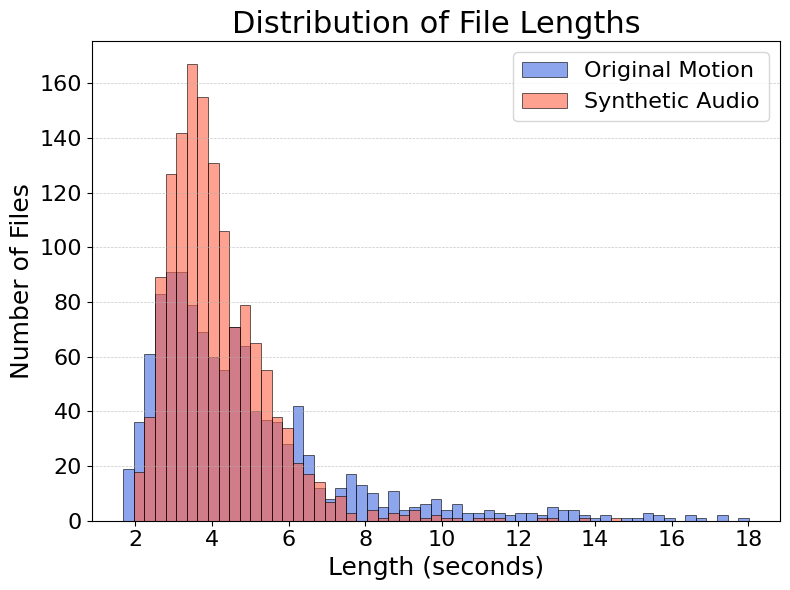

In [219]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(df1, df2, title, save_path):
    """
    Histogram with bigger text sizes for better readability.
    """
    plt.figure(figsize=(8, 6))

    # Merge lengths for consistent bins
    all_lengths = np.concatenate([df1['Length'].values, df2['Length'].values])
    bins = np.histogram_bin_edges(all_lengths, bins='auto')

    # Plot
    plt.hist(df1['Length'], bins=bins, alpha=0.6, label=df1['Label'].iloc[0], color='royalblue', edgecolor='black', linewidth=0.7)
    plt.hist(df2['Length'], bins=bins, alpha=0.6, label=df2['Label'].iloc[0], color='tomato', edgecolor='black', linewidth=0.7)

    # Bigger font sizes!
    plt.xlabel('Length (seconds)', fontsize=18)
    plt.ylabel('Number of Files', fontsize=18)
    plt.title(title, fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    print(f"Saved histogram to {save_path}")

plot_histogram(df_pt, df_synth, 'Distribution of File Lengths', './histogram_len.pdf')


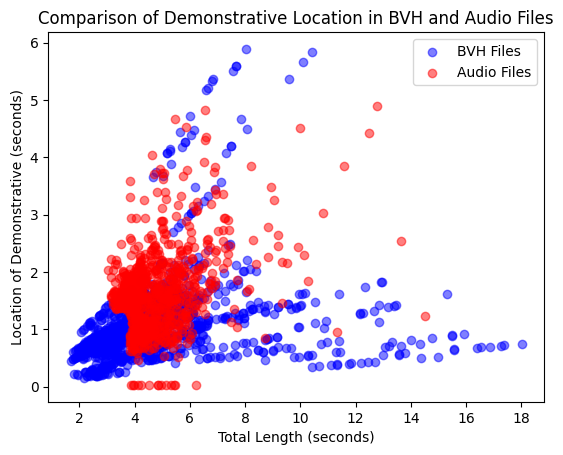

In [220]:
import matplotlib.pyplot as plt

# Let's assume you have two lists of tuples containing (total_length, index_time)
# One for BVH files and one for audio files, where each tuple corresponds to a matched pair.
bvh_data = pt_times  # replace with your actual data
audio_data = synth_times# replace with your actual data
# audio_data = [(x[0],x[1]+0.5) for x in audio_data]

# Unzip the tuples to get separate lists for total length and index time for each dataset
bvh_lengths, bvh_indices = zip(*bvh_data)
audio_lengths, audio_indices = zip(*audio_data)

# Create a scatter plot
plt.scatter(bvh_lengths, bvh_indices, alpha=0.5, color='blue', label='BVH Files')
plt.scatter(audio_lengths, audio_indices, alpha=0.5, color='red', label='Audio Files')

# Add labels and legend
plt.xlabel('Total Length (seconds)')
plt.ylabel('Location of Demonstrative (seconds)')

plt.title('Comparison of Demonstrative Location in BVH and Audio Files')
plt.legend()

# Show the plot
plt.show()


In [221]:
# Convert the list to a numpy array for statistical calculations
synth_lengths_array = np.array([x[0] for x in synth_times])
print(synth_lengths_array)
lengths_array = np.array(synth_lengths_array)

lengths_array_pt = np.array([x[0] for x in pt_times])
# Calculate the mean and standard deviation
mean_length = np.mean(lengths_array)
std_dev_length = np.std(lengths_array)

# Calculate the 50th (median) and 75th percentiles
median_length_syn = np.percentile(lengths_array, 50)
percentile_75_length = np.percentile(lengths_array, 75)
percentile_75_length

cutoff_time_syn = median_length_syn

median_length_pt = np.percentile(lengths_array_pt, 50)
percentile_75_length = np.percentile(lengths_array, 75)
percentile_75_length

cutoff_time_pt = median_length_pt

print(len(pt_data))
print(len(synth_data))

short_pt = {k:v for k,v in pt_data.items() if v[1]<cutoff_time_pt}
short_synth = {k:v for k,v in synth_data.items() if v[1]<cutoff_time_syn}
long_pt = {k:v for k,v in pt_data.items() if v[1]>=cutoff_time_pt}
long_synth = {k:v for k,v in synth_data.items() if v[1]>=cutoff_time_syn}

synth_pre_short = {k:v for k,v in synth_pre.items() if k in short_synth}
synth_post_short = {k:v for k,v in synth_post.items() if k in short_synth}
pt_pre_short = {k:v for k,v in pt_pre.items() if k in short_pt}
pt_post_short = {k:v for k,v in pt_post.items() if k in short_pt}



[ 4.576       5.06666667  4.59733333  3.81866667  5.61066667  5.36533333
  6.73066667  4.45866667  5.024       4.96        7.37066667  6.92266667
  7.21066667  3.70133333  4.59733333  5.28        4.27733333  3.57333333
  4.59733333  5.61066667  6.51733333  5.55733333  5.01333333  4.33066667
  5.86666667  4.07466667  3.86133333  5.26933333  6.34666667  6.15466667
  3.94666667  6.61333333  6.208       3.94666667  4.10666667  3.712
  4.16        3.552       3.92533333  3.904       6.12266667  3.65866667
  5.71733333  4.32        4.992       4.07466667  3.40266667  3.904
  4.512       4.27733333  4.91733333  4.26666667  5.81333333  4.32
  4.34133333  3.968       5.29066667  4.43733333  6.79466667  4.11733333
  5.42933333  4.096       5.376       4.20266667  3.712       5.16266667
  4.07466667  3.62666667  4.18133333  4.02133333  4.08533333  4.
  5.48266667  4.66133333  5.984       4.18133333  5.48266667  4.14933333
  3.91466667  5.86666667  3.97866667  4.04266667  6.02666667  5.38666667
  

In [222]:
# make distance matrix
D = []
synth_pre = synth_pre_short
synth_post = synth_post_short
pt_pre = pt_pre_short
pt_post = pt_post_short

for syntitem in list(synth_pre.keys())[:]:
    row = []
    for pointitem in list(pt_pre.keys())[:]:
        syntpre = synth_pre[syntitem]
        syntpost = synth_post[syntitem]
        pointpre = pt_pre[pointitem]
        pointpost = pt_post[pointitem]

        cost = abs(syntpre-pointpre) + abs(syntpost-pointpost)
        if synth_length[syntitem] > point_length[pointitem]:
            cost *= 10
        # penalize if synt starts before or ends after point
        if syntpre > pointpre:
            cost *= 2
        if syntpost > pointpost:
            cost *= 2
        row.append(cost)
    
    D.append(row)
dd = np.array(D)
dd.shape

(416, 573)

In [187]:
!pip install munkres

  Using cached munkres-1.1.4-py2.py3-none-any.whl (7.0 kB)


In [224]:
from munkres import Munkres
m = Munkres()
assignment_re = m.compute(D)
f = open('assignment_short.csv','w')
f.write('syntitem,pointitem,offset\n')
for pair in assignment_re:
    syntidx,pointidx = pair
    syntitem = list(synth_pre.keys())[syntidx]
    pointitem = list(pt_pre.keys())[pointidx]
    f.write('{},{},{}\n'.format(syntitem, pointitem, pt_pre[pointitem]-synth_pre[syntitem]))
f.close()

In [193]:
selected = []
with open("/tmp/assignment_short.csv") as f:
    for line in f.readlines():
        line = line.strip()
        if line.startswith("syntitem"):
            continue
        parts = line.split(",")
        selected.append(parts[0])

In [195]:
filtered = []
with open("/tmp/procced2.1.json") as inf:
    newdata = json.load(inf)
for item in newdata:
    if item["fileid"] in selected:
        filtered.append(item)

In [198]:
# ffmpeg -i /tmp/output/st2_mirrored.10512_10854_1.23stretch.mp4 -i groundinggpt-generated-speech/hsi_4_0717_211_001_main__ggpt__682.wav -filter_complex "[1:a]atrim=start=0.8624999999999999[aud]" -map 0:v -map "[aud]" -c:v copy -c:a aac output_minus.mp4

with open("/tmp/assignment_short.csv") as f, open("/tmp/ffmpeg-runner.sh", "w") as outf:
    for line in f.readlines():
        line = line.strip()
        if line.startswith("syntitem"):
            continue
        parts = line.split(",")
        
        outf.write(f"ffmpeg -i /tmp/output/{parts[1]}.mp4 -i /tmp/groundinggpt-generated-speech/{parts[0]}.wav")
        time = float(parts[2])
        if time < 0.0:
            outf.write(f" -filter_complex \"[1:a]atrim=start={time}[aud]\" -map 0:v -map \"[aud]\"")
        else:
            itime = int(time * 1000.0)
            outf.write(f" -filter_complex \"[1:a]adelay={itime}|{itime}[aud]\" -map 0:v -map \"[aud]\"")
        outf.write(f" -c:v copy -c:a aac /tmp/output_minus/{parts[0]}.mp4\n")


In [201]:
filtered_dict = {x["fileid"]: x for x in filtered}

In [203]:
with open("/tmp/assignment_short.csv") as f, open("/tmp/assigned_extended.csv", "w") as outf:
    for line in f.readlines():
        line = line.strip()
        if line.startswith("syntitem"):
            outf.write(line + ",room,topic\n")
            continue
        parts = line.split(",")
        cur = filtered_dict[parts[0]]
        outf.write(f"{line},{cur['room']},{cur['topic']}\n")
